In [103]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import os

In [104]:
# Load Data
print("Working directory:", os.getcwd())

data_dir = "../data/raw/"
bridges_path = os.path.join(data_dir, "BMMS_overview.xlsx")
roads_path = os.path.join(data_dir, "_roads3.csv")


Working directory: C:\Users\audiv\PycharmProjects\AdvancedSimulation\EPA133a-G04-A3\data


In [105]:
# Read data
bridges = pd.read_excel(bridges_path)
roads = pd.read_csv(roads_path)
gdf = gpd.GeoDataFrame(roads, geometry=gpd.points_from_xy(roads.lon, roads.lat))

In [106]:
display(roads.head())

,road,chainage,lrp,lat,lon,gap,type,name
0,N1,0.000,LRPS,23.706028,90.443333,NaN,Others,Start of Road after Jatrabari Flyover infront...
1,N1,0.814,LRPSa,23.702917,90.450417,NaN,Culvert,Box Culvert
2,N1,0.822,LRPSb,23.702778,90.450472,NaN,CrossRoad,Intersection with Z1101
3,N1,1.000,LRP001,23.702139,90.451972,NaN,KmPost,Km post missing
4,N1,2.000,LRP002,23.697889,90.460583,NaN,KmPost,Km post missing


In [107]:
# Plot function to plot the roads on a map
def plot_roads(gdf, label0, title, highlight=None, highlight_label=None, highlight2=None, highlight_label2=None):
    fig, ax = plt.subplots(figsize=(8,8))
    gdf.plot(ax=ax, color='blue', markersize=1, label=label0)

    if highlight is not None:
        highlight.plot(ax=ax, color='red', markersize=3, label=highlight_label)

    if highlight2 is not None:
        highlight2.plot(ax=ax, color='green', markersize=3, label=highlight_label2)

    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_aspect('equal')
    fig.suptitle(title, fontsize=15)
    fig.tight_layout()
    plt.legend()
    plt.show()

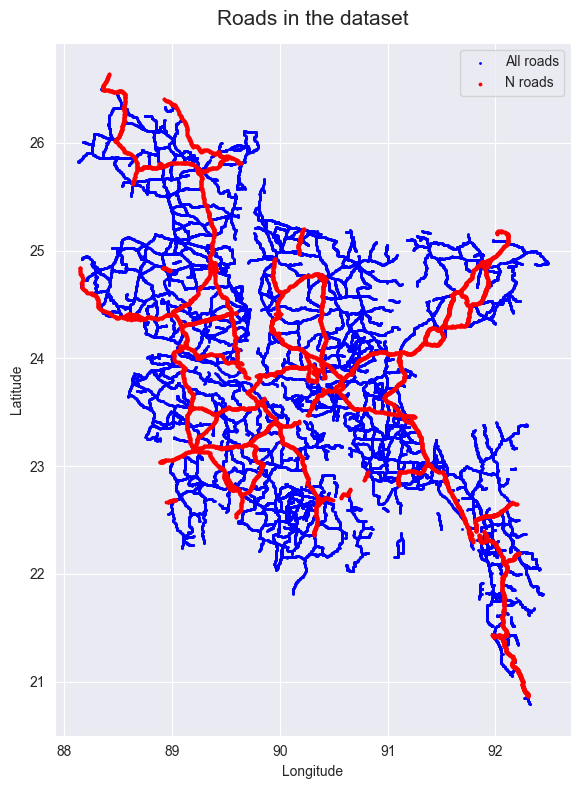

In [108]:
plot_roads(gdf, 'All roads', 'Roads in the dataset', highlight=gdf[gdf['road'].str.contains('N')], highlight_label='N roads')

### Identification of the N roads with intersections to the N1 and N2

In [109]:
n_roads = gdf[gdf['road'].str.contains('N')]
n1 = n_roads[n_roads['road'] == 'N1']
n2 = n_roads[n_roads['road'] == 'N2']

C:\Users\audiv\AppData\Local\Temp\ipykernel_19964\1583411028.py:5: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buffer_union = n_main['buffer_geom'].unary_union


Roads intersecting the N1 or N2 and longer than 25 km: ['N1' 'N102' 'N104' 'N105' 'N2' 'N204' 'N207' 'N208']


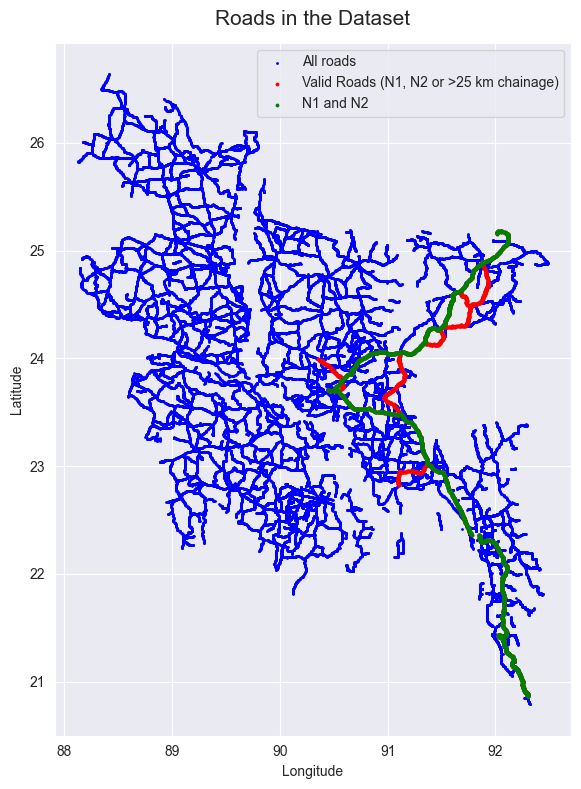

In [110]:
n_main = gpd.GeoDataFrame(pd.concat([n1, n2], ignore_index=True), crs=n1.crs)
n_main['buffer_geom'] = n_main.geometry.buffer(0.18)

# Combine all buffer geometries into a single geometry using unary_union
buffer_union = n_main['buffer_geom'].unary_union
roads_within = n_roads[n_roads.geometry.intersects(buffer_union)]

max_chainage = roads_within.groupby('road')['chainage'].max().reset_index()

# Filter: always include N1 and N2; for side roads, only include if max chainage > 25 km
valid_roads = max_chainage[
    (max_chainage['road'].isin(['N1', 'N2'])) |
    (max_chainage['chainage'] > 25)
]

# Filter the original roads based on the valid roads list
valid_roads = gdf[gdf['road'].isin(valid_roads['road'])]
print(f'Roads intersecting the N1 or N2 and longer than 25 km: {valid_roads.road.unique()}')

# Plot the final roads
plot_roads(
    gdf,
    label0='All roads',
    title='Roads in the Dataset',
    highlight=valid_roads,
    highlight_label='Valid Roads (N1, N2 or >25 km chainage)',
    highlight2=n_main,
    highlight_label2='N1 and N2'
)

### Identify the intersection locations of the roads

,road,chainage,lrp,lat,lon,gap,type,name,geometry
0,N1,0.822,LRPSb,23.702778,90.450472,NaN,CrossRoad,Intersection with Z1101,POINT (90.45047 23.70278)
1,N1,7.181,LRP007a,23.697916,90.509278,NaN,CrossRoad,"R110,Left to Demra, Right to Narayanganj",POINT (90.50928 23.69792)
2,N1,85.897,LRP088a,23.459000,91.142333,NaN,CrossRoad,Cross road Z1029,POINT (91.14233 23.459)
3,N1,87.366,LRP089c,23.446944,91.148139,NaN,CrossRoad,Cross Road with Z1052,POINT (91.14814 23.44694)
4,N1,91.583,LRP094a,23.419138,91.172194,NaN,CrossRoad,Left to Comilla Right to Noakhali,POINT (91.17219 23.41914)
5,N1,140.251,LRP143a,23.047944,91.365139,NaN,CrossRoad,Z1031,POINT (91.36514 23.04794)
6,N1,145.409,LRP148a,23.009556,91.381360,NaN,CrossRoad / KmPost,Intersection with N104 / Km post missing,POINT (91.38136 23.00956)
7,N1,255.726,LRP259b,22.309694,91.915750,NaN,CrossRoad,Road to Kaliganj (Z1070),POINT (91.91575 22.30969)
8,N1,330.874,LRP335c,21.773722,92.084055,NaN,CrossRoad,Intersection with Z1126,POINT (92.08406 21.77372)
9,N1,0.000,LRPS,23.706028,90.443333,NaN,Others,Start of Road after Jatrabari Flyover infront...,POINT (90.44333 23.70603)


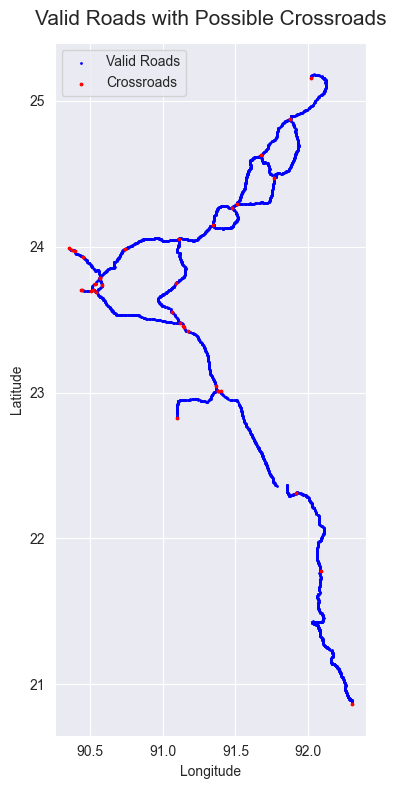

In [111]:
# Loop through each road in valid roads, and display the crossroads
crossroads_list = []
for road in valid_roads['road'].unique():
    road_data = valid_roads[valid_roads['road'] == road]
    crossroads = road_data[road_data['type'].str.contains('CrossRoad')]

    # Add the beginning and end points of the road to the crossroads
    crossroads = pd.concat([crossroads, road_data.iloc[[0, -1]]])
    crossroads_list.append(crossroads)

possible_crossroads = pd.concat(crossroads_list, ignore_index=True)
display(possible_crossroads)

plot_roads(valid_roads, 'Valid Roads', 'Valid Roads with Possible Crossroads', highlight=possible_crossroads, highlight_label='Crossroads')


,road,chainage,lrp,lat,lon,gap,type,name,geometry
6,N1,145.409,LRP148a,23.009556,91.381360,NaN,CrossRoad / KmPost,Intersection with N104 / Km post missing,POINT (91.38136 23.00956)
13,N102,0.000,LRPS,23.478972,91.118194,NaN,Others,Start of road from N1 Mainamati,POINT (91.11819 23.47897)
14,N102,82.682,LRPE,24.050611,91.114667,NaN,Others,Meet with N 2 at Sanail,POINT (91.11467 24.05061)
15,N104,1.878,LRP001a,23.009528,91.381444,NaN,CrossRoad,Right to Comilla Left to Chittagong,POINT (91.38144 23.00953)
19,N105,12.803,LRP012a,23.785194,90.568805,NaN,CrossRoad,N2 Dhaka-Sylhet -Jaflong Road,POINT (90.5688 23.78519)
23,N105,0.000,LRPS,23.690416,90.546611,NaN,Others,"Starts of road from N1,Dhaka teknaf road at Ma...",POINT (90.54661 23.69042)
26,N2,11.464,LRP012a,23.785333,90.568555,NaN,CrossRoad,Intersection with N105,POINT (90.56855 23.78533)
28,N2,0.000,LRPS,23.705917,90.521444,NaN,Others,Road Start from N1 at Katchpur,POINT (90.52144 23.70592)
30,N204,0.000,LRPS,24.147916,91.346611,NaN,Others,Road start from N2 at Jagannathganj.,POINT (91.34661 24.14792)
31,N204,34.421,LRPE,24.267388,91.477138,NaN,Others,Road End intersecting N2 at Shaistagonj Round ...,POINT (91.47714 24.26739)


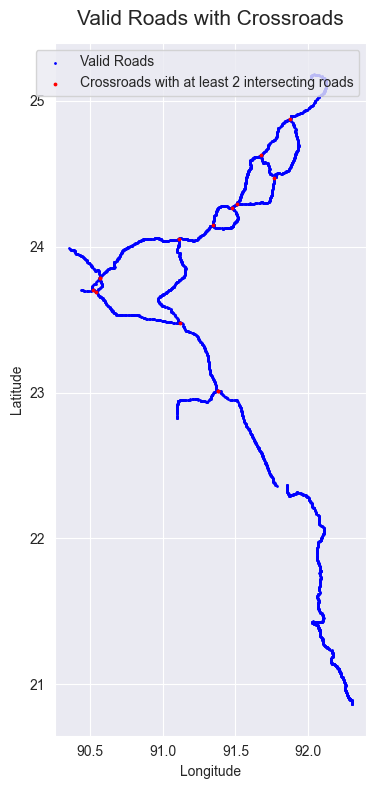

In [112]:
# check if these possible crossroads intersect with at least 2 roads
crossroad_intersections = []

def check_crossroad_intersections(possible_crossroads, valid_roads):
    # Create a small buffer around each possible crossroad
    possible_crossroads['buffer_geom'] = possible_crossroads.geometry.buffer(0.005)

    for idx, crossroad in possible_crossroads.iterrows():
        # Check how many roads intersect with the buffer
        roads_intersecting = valid_roads[valid_roads.geometry.intersects(crossroad['buffer_geom'])]
        if roads_intersecting['road'].nunique() >= 2:
            crossroad_intersections.append(crossroad)

    return

check_crossroad_intersections(possible_crossroads, valid_roads)
crossroad_intersections = pd.DataFrame(crossroad_intersections).drop(columns='buffer_geom')
crossroad_intersections = gpd.GeoDataFrame(crossroad_intersections, geometry='geometry')
display(crossroad_intersections)

plot_roads(valid_roads, 'Valid Roads', 'Valid Roads with Crossroads', highlight=crossroad_intersections, highlight_label='Crossroads with at least 2 intersecting roads')

These are the correct crossroads, however there are a few duplicate locations, with almost the same latitude and longitude. These duplicates will first be identified.


In [113]:
# Identify the (almost) duplicate locations

# Create a small buffer around each crossroad
crossroad_intersections['buffer_geom'] = crossroad_intersections.geometry.buffer(0.001)

# Check for intersections between the buffers
crossroad_duplicates = []
for idx, crossroad in crossroad_intersections.iterrows():
    intersections = crossroad_intersections[crossroad_intersections.geometry.intersects(crossroad['buffer_geom'])]
    if len(intersections) > 1:
        crossroad_duplicates.append(intersections.index)

display(crossroad_duplicates)

[Index([6, 15], dtype='int64'),
 Index([6, 15], dtype='int64'),
 Index([19, 26], dtype='int64'),
 Index([19, 26], dtype='int64')]

So the duplicate crossroads are the one with index 6 & 15, and the one with index 19 & 26. In both cases we choose to keep the locations of the crossroad whcihc point originates from the N1 or N2 road data. The other ones are dropped in the code below.

In [114]:
# Remove the duplicates
try:
    crossroad_intersections = crossroad_intersections.drop(index=15)
    crossroad_intersections = crossroad_intersections.drop(index=19)
except KeyError:
    pass

# Remove the buffer geometry
try:
    crossroad_intersections = crossroad_intersections.drop(columns='buffer_geom')
except KeyError:
    pass

# display the final crossroads
display(crossroad_intersections)

,road,chainage,lrp,lat,lon,gap,type,name,geometry
6,N1,145.409,LRP148a,23.009556,91.381360,NaN,CrossRoad / KmPost,Intersection with N104 / Km post missing,POINT (91.38136 23.00956)
13,N102,0.000,LRPS,23.478972,91.118194,NaN,Others,Start of road from N1 Mainamati,POINT (91.11819 23.47897)
14,N102,82.682,LRPE,24.050611,91.114667,NaN,Others,Meet with N 2 at Sanail,POINT (91.11467 24.05061)
23,N105,0.000,LRPS,23.690416,90.546611,NaN,Others,"Starts of road from N1,Dhaka teknaf road at Ma...",POINT (90.54661 23.69042)
26,N2,11.464,LRP012a,23.785333,90.568555,NaN,CrossRoad,Intersection with N105,POINT (90.56855 23.78533)
28,N2,0.000,LRPS,23.705917,90.521444,NaN,Others,Road Start from N1 at Katchpur,POINT (90.52144 23.70592)
30,N204,0.000,LRPS,24.147916,91.346611,NaN,Others,Road start from N2 at Jagannathganj.,POINT (91.34661 24.14792)
31,N204,34.421,LRPE,24.267388,91.477138,NaN,Others,Road End intersecting N2 at Shaistagonj Round ...,POINT (91.47714 24.26739)
32,N207,0.000,LRPS,24.294861,91.510250,NaN,Others,Road start from N2 at Mirpur.,POINT (91.51025 24.29486)
33,N207,67.985,LRPE,24.626333,91.677527,NaN,Others,Road end with N2 at Mukti joddha Chattor Sherpur.,POINT (91.67753 24.62633)


In [115]:
# Ensure valid_roads and crossroad_intersections are GeoDataFrames
if not isinstance(valid_roads, gpd.GeoDataFrame):
    valid_roads = gpd.GeoDataFrame(valid_roads, geometry='geometry')

if not isinstance(crossroad_intersections, gpd.GeoDataFrame):
    crossroad_intersections = gpd.GeoDataFrame(crossroad_intersections, geometry='geometry')

In [116]:
# Create a copy of valid_roads to avoid modifying a slice
valid_roads = valid_roads.copy()

# Check for intersections safely
valid_roads.loc[:, 'is_intersection'] = valid_roads.geometry.apply(
    lambda geom: crossroad_intersections.geometry.intersects(geom).any()
)


In [117]:
# Assign model_type based on intersection check
valid_roads.loc[:, 'model_type'] = valid_roads['is_intersection'].map({True: 'intersection', False: 'other'})

In [118]:
display(valid_roads)

,road,chainage,lrp,lat,lon,gap,type,name,geometry,is_intersection,model_type
0,N1,0.000,LRPS,23.706028,90.443333,NaN,Others,Start of Road after Jatrabari Flyover infront...,POINT (90.44333 23.70603),False,other
1,N1,0.814,LRPSa,23.702917,90.450417,NaN,Culvert,Box Culvert,POINT (90.45042 23.70292),False,other
2,N1,0.822,LRPSb,23.702778,90.450472,NaN,CrossRoad,Intersection with Z1101,POINT (90.45047 23.70278),False,other
3,N1,1.000,LRP001,23.702139,90.451972,NaN,KmPost,Km post missing,POINT (90.45197 23.70214),False,other
4,N1,2.000,LRP002,23.697889,90.460583,NaN,KmPost,Km post missing,POINT (90.46058 23.69789),False,other
...,...,...,...,...,...,...,...,...,...,...,...
3684,N208,54.585,LRP056,24.855778,91.888111,NaN,KmPost,Sylhet 7 km,POINT (91.88811 24.85578),False,other
3685,N208,55.510,LRP056a,24.861528,91.881860,NaN,Culvert,Box culvert,POINT (91.88186 24.86153),False,other
3686,N208,55.595,LRP057,24.861889,91.881027,NaN,KmPost,Sylhet 6 km,POINT (91.88103 24.86189),False,other
3687,N208,56.595,LRP058,24.869499,91.876027,NaN,KmPost,Sylhet 5 km,POINT (91.87603 24.8695),False,other


In [119]:
#filter bridges
bridges = bridges[bridges['road'].str.match(r'^(N1|N2)\d*$', na=False)]

In [120]:
# Save the filtered roads and bridges for further processing
data_direct = "../data/"
valid_roads.to_csv(os.path.join(data_direct, "roads_filtered.csv"), index=False)
bridges.to_csv(os.path.join(data_direct, "bridges_filtered.csv"), index=False)

In [121]:
# Assuming you've already saved your filtered data:
roads = pd.read_csv("../data/roads_filtered.csv")    # e.g. columns: [road, chainage, lat, lon, type, name, is_intersection, ...]
bridges = pd.read_csv("../data/bridges_filtered.csv") # e.g. columns: [road, km (chainage), lat, lon, type, name, condition, length, ...]

In [122]:
# 2.1 Rename chainage column if needed
# roads may already have a 'chainage' column, so no change is required.
# If your chainage column is named differently (e.g. "km"), rename it:
# roads.rename(columns={'km': 'chainage'}, inplace=True)

# 2.2 Create a new DataFrame with the columns you need
roads_df = pd.DataFrame()
roads_df['road'] = roads['road']
roads_df['chainage'] = roads['chainage']
roads_df['lat'] = roads['lat']
roads_df['lon'] = roads['lon']
roads_df['name'] = roads['name']

# We'll set 'condition' to NaN for roads (since it usually applies to bridges)
roads_df['condition'] = np.nan

# We'll leave 'length' at 0 or NaN for now—unless you have a specific way
# to calculate length for road segments:
roads_df['length'] = 0

# 2.3 Determine model_type for roads
#    - If is_intersection == True, then 'intersection'
#    - Otherwise, default to 'link'
roads_df['model_type'] = np.where(
    roads['is_intersection'] == True,
    'intersection',
    'link'
)


In [123]:
bridges_df = pd.DataFrame()
bridges_df['road'] = bridges['road']

# If your bridges have a column called 'km' for chainage, rename it:
# bridges.rename(columns={'km': 'chainage'}, inplace=True)
bridges_df['chainage'] = bridges['chainage']  # or 'chainage' if already named that

bridges_df['lat'] = bridges['lat']
bridges_df['lon'] = bridges['lon']
bridges_df['name'] = bridges['name']
bridges_df['condition'] = bridges['condition']
bridges_df['length'] = bridges['length']  # from the bridges data
bridges_df['model_type'] = 'bridge'


In [124]:
df_combined = pd.concat([roads_df, bridges_df], ignore_index=True)


In [125]:
def label_sourcesink(group):
    min_chain = group['chainage'].min()
    max_chain = group['chainage'].max()


    # Mark rows that match min or max chainage
    mask_min = (group['chainage'] == min_chain) & (group['model_type'].isna())
    mask_max = (group['chainage'] == max_chain) & (group['model_type'].isna())

    group.loc[mask_min, 'model_type'] = 'sourcesink'
    group.loc[mask_max, 'model_type'] = 'sourcesink'

    return group

df_combined = df_combined.groupby('road', group_keys=False).apply(label_sourcesink)
display(df_combined[df_combined['model_type'] == 'intersection'])


,road,chainage,lat,lon,name,condition,length,model_type
335,N1,145.409,23.009556,91.381360,Intersection with N104 / Km post missing,NaN,0.0,intersection
1339,N102,0.000,23.478972,91.118194,Start of road from N1 Mainamati,NaN,0.0,intersection
1557,N102,82.682,24.050611,91.114667,Meet with N 2 at Sanail,NaN,0.0,intersection
1681,N105,0.000,23.690416,90.546611,"Starts of road from N1,Dhaka teknaf road at Ma...",NaN,0.0,intersection
1798,N2,0.000,23.705917,90.521444,Road Start from N1 at Katchpur,NaN,0.0,intersection
1816,N2,11.464,23.785333,90.568555,Intersection with N105,NaN,0.0,intersection
2684,N204,0.000,24.147916,91.346611,Road start from N2 at Jagannathganj.,NaN,0.0,intersection
2776,N204,34.421,24.267388,91.477138,Road End intersecting N2 at Shaistagonj Round ...,NaN,0.0,intersection
2777,N207,0.000,24.294861,91.510250,Road start from N2 at Mirpur.,NaN,0.0,intersection
2942,N207,67.985,24.626333,91.677527,Road end with N2 at Mukti joddha Chattor Sherpur.,NaN,0.0,intersection


In [126]:
df_combined = df_combined.sort_values(by=['road', 'chainage']).reset_index(drop=True)


In [127]:
start_id = 1000000
df_combined['id'] = range(start_id, start_id + len(df_combined))


In [128]:
# 2. For each road, shift the chainage and compute the difference
df_combined['prev_chainage'] = df_combined.groupby('road')['chainage'].shift(1)

# 3. Calculate segment length as chainage - prev_chainage
df_combined['length'] = df_combined['chainage'] - df_combined['prev_chainage']

# 4. For the first row of each road (where prev_chainage is NaN), fill with 0
df_combined['length'] = df_combined['length'].fillna(0)

# 5. Drop the helper column if you like
df_combined.drop(columns=['prev_chainage'], inplace=True)

# Now df_combined['length'] contains the segment length in the same unit as chainage.

In [129]:
df_combined = df_combined[[
    'road',
    'id',
    'model_type',
    'condition',
    'name',
    'lat',
    'lon',
    'length'
]]

In [130]:
display(df_combined.head(40))
df_combined.to_csv("../data/final_n1_n2.csv", index=False)


,road,id,model_type,condition,name,lat,lon,length
0,N1,1000000,link,NaN,Start of Road after Jatrabari Flyover infront...,23.706028,90.443333,0.000
1,N1,1000001,link,NaN,Box Culvert,23.702917,90.450417,0.814
2,N1,1000002,link,NaN,Intersection with Z1101,23.702778,90.450472,0.008
3,N1,1000003,link,NaN,Km post missing,23.702139,90.451972,0.178
4,N1,1000004,bridge,A,.,23.698739,90.458861,0.800
5,N1,1000005,link,NaN,Km post missing,23.697889,90.460583,0.200
6,N1,1000006,link,NaN,Box culvert,23.697361,90.461667,0.130
7,N1,1000007,link,NaN,Km post missing,23.693833,90.469138,0.870
8,N1,1000008,link,NaN,Km post missing,23.693611,90.478777,1.000
9,N1,1000009,link,NaN,Road to Narayanganj(R111),23.693805,90.480527,0.175


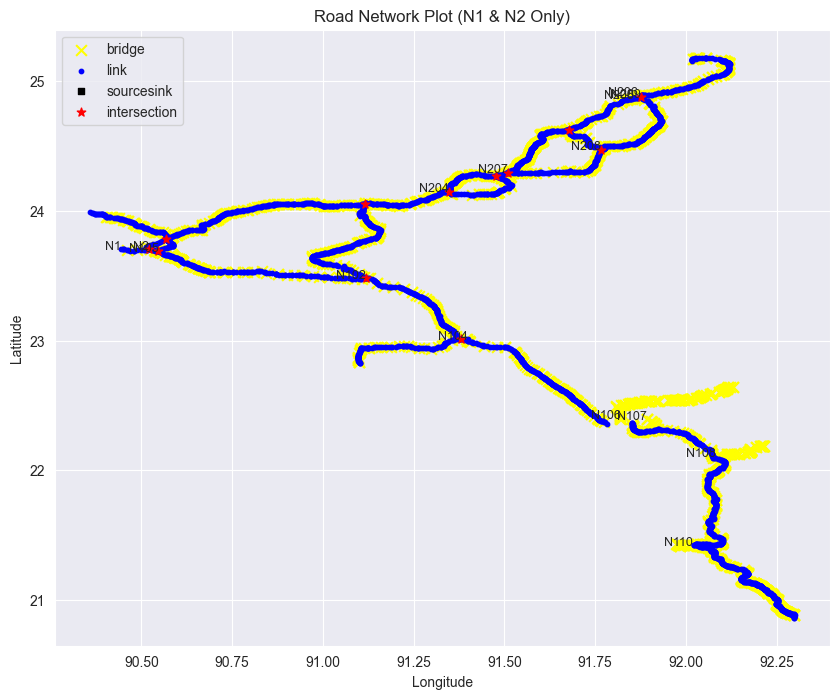

In [131]:
import pandas as pd
import matplotlib.pyplot as plt

df_combined = pd.read_csv("../data/final_n1_n2.csv")

colors = {
    'bridge': 'yellow',
    'link': 'blue',
    'sourcesink': 'black',
    'intersection': 'red'
}

markers = {
    'bridge': 'x',
    'link': 'o',
    'sourcesink': 's',
    'intersection': '*'
}

marker_sizes = {
    'bridge': 60,
    'link': 10,
    'sourcesink': 20,
    'intersection': 40
}

plt.figure(figsize=(10, 8))

for model_type, color in colors.items():
    subset = df_combined[df_combined['model_type'] == model_type]
    plt.scatter(subset['lon'], subset['lat'], c=color, label=model_type, s=marker_sizes[model_type],
                marker=markers[model_type])

for road in df_combined['road'].unique():
    first_point = df_combined[df_combined['road'] == road].iloc[0]
    plt.text(first_point['lon'], first_point['lat'], road, fontsize=9, ha='right')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Road Network Plot (N1 & N2 Only)')
plt.legend()
plt.show()